# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**_ Namita Karnik _

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
#!pip install keras
#!pip install keras
#!pip install tensorflow

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

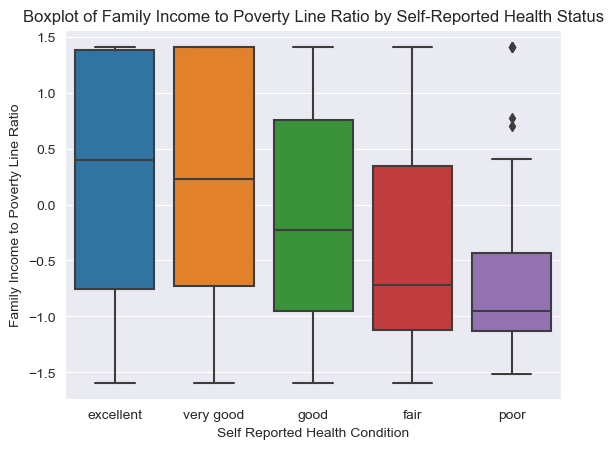

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

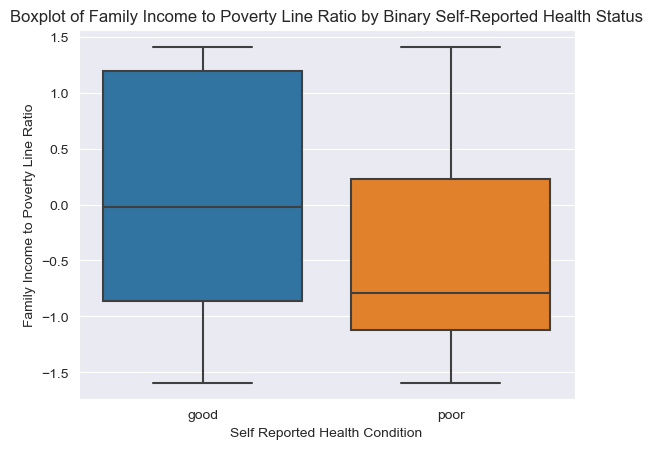

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

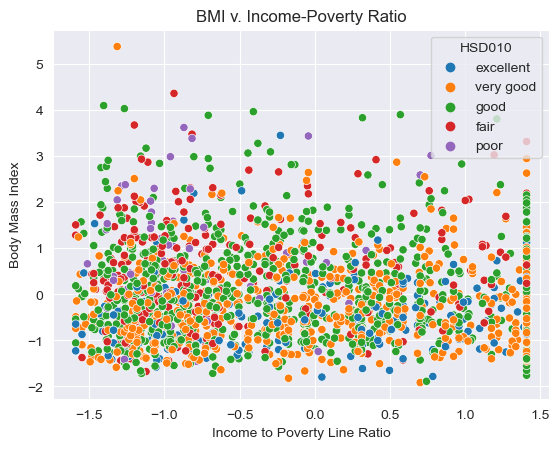

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [7]:
#ran these in anticipation of the PCA

features = nhanes_scaled.columns
features_labels = np.append(features, 'label')

X = nhanes_scaled.loc[:, features].values
X = StandardScaler().fit_transform(X) 

#X

#features_labels

#Also, I'm replacing 

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components
### And plot of Components

*Ans: I ran a Scree Plot to see how many PCA components to retain. I first ran it without specifying the number of components, but given that the dataset includes more than 200 components, it was hard to figure out what the ideal number of components would be from the graph. I then ran it by specifying the number as 20, which has been shown below. I decided that the ideal number of principal components would be 6, because it explains more than 80% of the variance.*

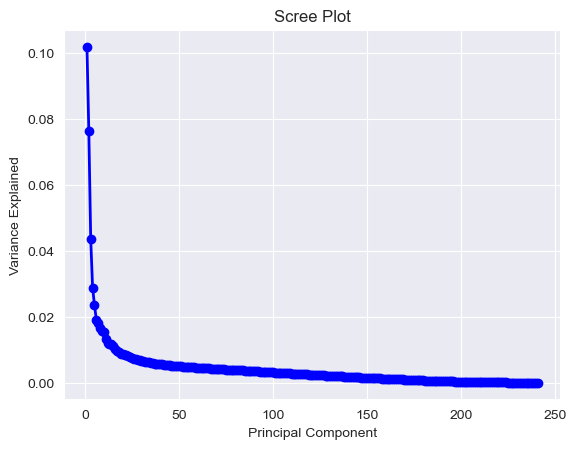

In [8]:
#Running the first PCA without specifing the number of components because I want want to keep them all

from sklearn.decomposition import PCA

pca_all = PCA() 
principalComponents_breast = pca_all.fit_transform(X)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

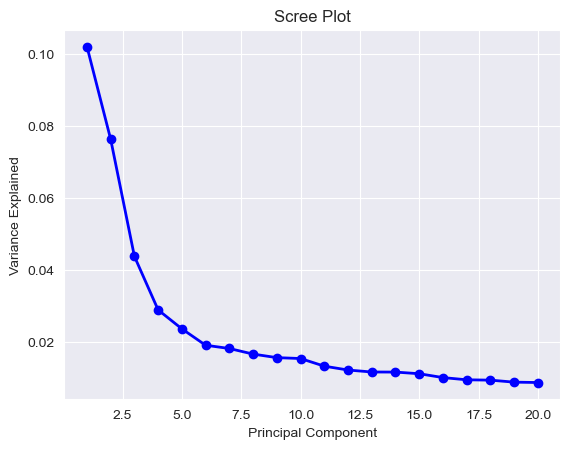

In [9]:
#Running it with n=20 to see what the explained variance is

from sklearn.decomposition import PCA

pca_all = PCA(n_components=20) # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes_scaled = pca_all.fit_transform(X)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### How many components will you use to fit a supervised learning model?

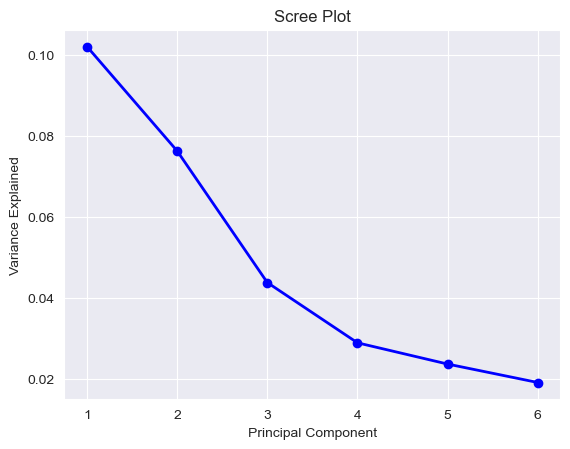

In [10]:
#I chose to run it with 6 components, since ot explains more than 80% of the variance. 

from sklearn.decomposition import PCA

pca_all = PCA(n_components=6) # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes_scaled = pca_all.fit_transform(X)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [11]:
pca = PCA(n_components=6)

pca = pca.fit_transform(nhanes_scaled)
pca.shape

pca_df = pd.DataFrame(data = principalComponents_nhanes_scaled, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                 'principal component 3',
                                 'principal component 4',
                                 'principal component 5',
                                 'principal component 6'])

pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,9.527811,-0.816224,-1.867106,-2.109688,-3.928200,-0.167260
1,-5.838339,-3.692574,3.805723,-1.029771,0.393607,1.604908
2,-0.719454,-2.573201,0.907896,-4.755612,-1.798845,0.864393
3,3.533627,-2.576983,-3.249172,-0.405865,3.993081,1.482657
4,-6.872094,-4.194241,0.886839,-0.848812,-0.524392,0.062547


### 2D Scatterplot of the first two components

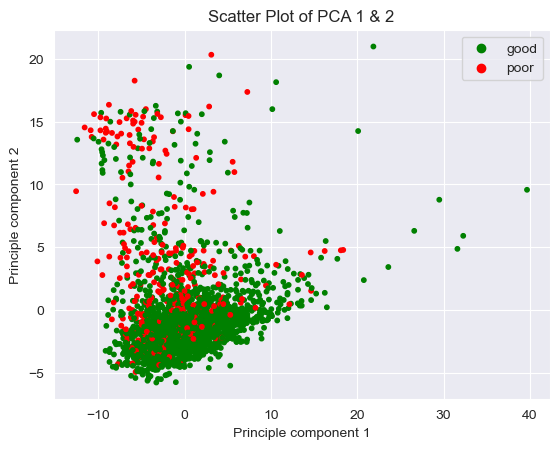

In [12]:
# Plot the scatter plot
# gen neccesary series
x_values = pca_df['principal component 1']
y_values = pca_df['principal component 2']

categories = hsd010_binary #which we had created earlier while making the boxplot

category_colors = {'good': 'green', 'poor': 'red'}

colors = [category_colors[category] for category in categories]

plt.scatter(x_values, y_values, c=colors , s=10)

for category, color in category_colors.items():
    plt.scatter([], [], color=color, label=category)  # Empty scatter plot for label
plt.legend()
plt.title('Scatter Plot of PCA 1 & 2')
plt.xlabel('Principle component 1')
plt.ylabel('Principle component 2')


plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

*Ans: I have chosen k means clustering as my clustering algorithm. It groups all data points into a cluster in such a way, that they're all similar to each other (it minimizes within cluster variation). It also keeps clusters as far away from each other as possible (when we repeat the steps). To select the optimal k value, I ploted the elbow method.*

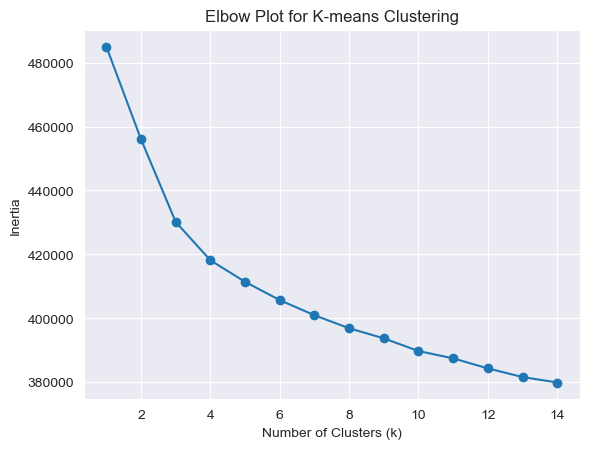

In [13]:
# Elbow method for K-Means
# Specify a range of k values
k_values = range(1, 15)

inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(nhanes_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow plot
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Plot for K-means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

### Cluster nhanes

In [14]:
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled)

*Ans: I chose k-4, because in this graph, there is a somewhat clear inflection point. Although the bend (elbow) isn't very distinct, visually, it seems like the data will have four main clusters.*

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

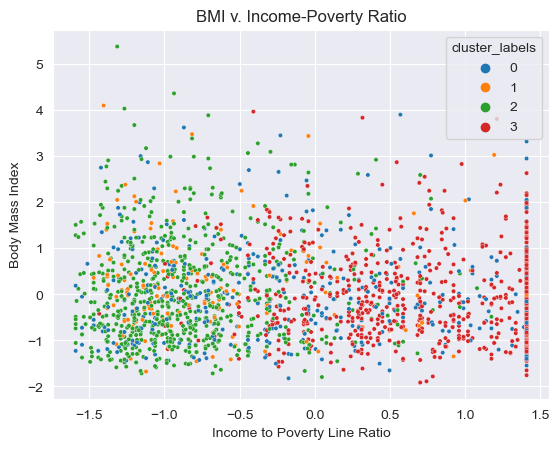

In [15]:
# record the clusters
cluster_labels = kmeans.predict(nhanes_scaled)
nhanes_scaled_cluster = nhanes_scaled
nhanes_scaled_cluster['cluster_labels'] = cluster_labels

# plot in BMI and Income-Poverty Ration axises
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "cluster_labels", palette = "tab10", data = nhanes_scaled_cluster, s=10)

#naming the x and y axis
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")

#naming the graph
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

This plot is a little tough to decipher. The red (cluster 3) and yellow spots (cluster 1) seem to be concentrated on the left side of the graph. 

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

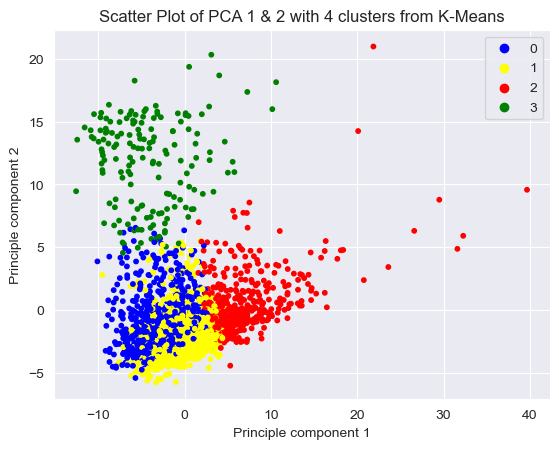

In [16]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(pca)
cluster = kmeans.predict(pca)


# Plot the scatter plot
# gen neccesary series
x_values = pca[:, 0]
y_values = pca[:, 1]
hsd010_binary = hsd010.replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
categories = hsd010_binary

categories = cluster

# Define colors for each category
category_colors = {0: 'blue', 1: 'yellow', 2: 'red', 3: 'green'}

# Map the categories to colors
colors = [category_colors[category] for category in categories]

# Plot the scatter plot with colored dots
plt.scatter(x_values, y_values, c=colors , s=10)
# Add labels for each color in the legend
for category, color in category_colors.items():
    plt.scatter([], [], color=color, label=category)  # Empty scatter plot for label
plt.legend()
plt.title('Scatter Plot of PCA 1 & 2 with 4 clusters from K-Means')
plt.xlabel('Principle component 1')
plt.ylabel('Principle component 2')

plt.show()

PCA clustering gives us better results than simply clustering the entire dataset. This is pretty obvious, since the PCA reduces dimentionality (by creating seperate features, as opposed to the ones that are within th dataset). This is helpful, because in cases like these, with many features, it is tough to select a few that matter most. PCA is a better approach. 

Thus the data clusters when shown in PCA are more distinct, because the Principal Components have been created specifically for this dataset. My cluster 1 and 3 however, are very close and even merge with one another. Which makes me think, maybe 3 or even 2 clusters would have been a better in terms of keeping these clusters separate. 

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

Ans: I chose HSD010 binary has my outcome, simply because I am more comfortable predict on a binary outcome, and also because I thought it would have a higher accuracy value, since we would be predicting 2 outcomes instead of 5. 

### Neural Network on Original Features

In [17]:
# partition data
# -----------
y = hsd010_binary.replace({'good': 0, 'poor': 1}) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop('cluster_labels', axis=1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU  # Import LeakyReLU directly

# create neural network model
# -----------
model = Sequential()

model.add(Dense(100, input_dim=241, kernel_initializer='glorot_uniform'))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU as activation function
model.add(Dense(1, kernel_initializer= 'glorot_uniform', activation= 'sigmoid'))

## Add any additional layers you wish here

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)

# Access the accuracy from the history object
training_accuracy = model.history['accuracy']  # Accuracy on the training set
validation_accuracy_accuracy = model.history['val_accuracy']  # Accuracy on the validation set

# Print the final accuracy values
print(f"Final Training Accuracy: {training_accuracy[-1]}")
print(f"Final Validation Accuracy: {validation_accuracy_accuracy[-1]}")

Epoch 1/20
8/8 - 0s - loss: 0.5004 - accuracy: 0.7907 - val_loss: 0.4246 - val_accuracy: 0.8198 - 322ms/epoch - 40ms/step
Epoch 2/20
8/8 - 0s - loss: 0.3728 - accuracy: 0.8456 - val_loss: 0.3808 - val_accuracy: 0.8353 - 21ms/epoch - 3ms/step
Epoch 3/20
8/8 - 0s - loss: 0.3238 - accuracy: 0.8689 - val_loss: 0.3649 - val_accuracy: 0.8488 - 23ms/epoch - 3ms/step
Epoch 4/20
8/8 - 0s - loss: 0.2963 - accuracy: 0.8798 - val_loss: 0.3584 - val_accuracy: 0.8527 - 22ms/epoch - 3ms/step
Epoch 5/20
8/8 - 0s - loss: 0.2713 - accuracy: 0.8928 - val_loss: 0.3574 - val_accuracy: 0.8527 - 23ms/epoch - 3ms/step
Epoch 6/20
8/8 - 0s - loss: 0.2501 - accuracy: 0.9005 - val_loss: 0.3518 - val_accuracy: 0.8527 - 23ms/epoch - 3ms/step
Epoch 7/20
8/8 - 0s - loss: 0.2327 - accuracy: 0.9083 - val_loss: 0.3485 - val_accuracy: 0.8624 - 22ms/epoch - 3ms/step
Epoch 8/20
8/8 - 0s - loss: 0.2173 - accuracy: 0.9134 - val_loss: 0.3502 - val_accuracy: 0.8585 - 22ms/epoch - 3ms/step
Epoch 9/20
8/8 - 0s - loss: 0.2032 - a

In [19]:
#creating these again because the previous model overrode some of the parameters. 

y = hsd010_binary.replace({'good': 0, 'poor': 1}) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = pca 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

### Neural Network on Principal Components

In [20]:
# partition data
# -----------

# the numbers of classes in y variable
num_classes = 2

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU  # Import LeakyReLU directly

# create neural network model
# -----------
model = Sequential()

model.add(Dense(100, input_dim=6, kernel_initializer='glorot_uniform'))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU as activation function
model.add(Dense(1, kernel_initializer= 'glorot_uniform', activation= 'sigmoid'))

## Add any additional layers you wish here

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)

# Access the accuracy from the history object
training_accuracy = model.history['accuracy']  # Accuracy on the training set
validation_accuracy = model.history['val_accuracy']  # Accuracy on the validation set

# Print the final accuracy values
print(f"Final Training Accuracy: {training_accuracy[-1]}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]}")

Epoch 1/20
8/8 - 0s - loss: 0.7588 - accuracy: 0.5271 - val_loss: 0.6374 - val_accuracy: 0.6570 - 256ms/epoch - 32ms/step
Epoch 2/20
8/8 - 0s - loss: 0.6128 - accuracy: 0.7313 - val_loss: 0.5314 - val_accuracy: 0.8062 - 18ms/epoch - 2ms/step
Epoch 3/20
8/8 - 0s - loss: 0.5156 - accuracy: 0.8165 - val_loss: 0.4684 - val_accuracy: 0.8469 - 20ms/epoch - 2ms/step
Epoch 4/20
8/8 - 0s - loss: 0.4585 - accuracy: 0.8288 - val_loss: 0.4318 - val_accuracy: 0.8469 - 21ms/epoch - 3ms/step
Epoch 5/20
8/8 - 0s - loss: 0.4252 - accuracy: 0.8372 - val_loss: 0.4097 - val_accuracy: 0.8450 - 20ms/epoch - 3ms/step
Epoch 6/20
8/8 - 0s - loss: 0.4049 - accuracy: 0.8430 - val_loss: 0.3942 - val_accuracy: 0.8527 - 21ms/epoch - 3ms/step
Epoch 7/20
8/8 - 0s - loss: 0.3925 - accuracy: 0.8450 - val_loss: 0.3848 - val_accuracy: 0.8547 - 20ms/epoch - 2ms/step
Epoch 8/20
8/8 - 0s - loss: 0.3848 - accuracy: 0.8475 - val_loss: 0.3797 - val_accuracy: 0.8527 - 21ms/epoch - 3ms/step
Epoch 9/20
8/8 - 0s - loss: 0.3797 - a

### Neural Network on Principal Components + Cluster Membership

In [21]:
# the numbers of classes in y variable
num_classes = 2

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU  # Import LeakyReLU directly

# create neural network model
# -----------
model = Sequential()

model.add(Dense(100, input_dim=6, kernel_initializer='glorot_uniform'))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU as activation function
model.add(Dense(1, kernel_initializer= 'glorot_uniform', activation= 'sigmoid'))

## Add any additional layers you wish here

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)

# Access the accuracy from the history object
training_accuracy = model.history['accuracy']  # Accuracy on the training set
validation_accuracy = model.history['val_accuracy']  # Accuracy on the validation set

# Print the final accuracy values
print(f"Final Training Accuracy: {training_accuracy[-1]}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]}")

Epoch 1/20
8/8 - 0s - loss: 0.8962 - accuracy: 0.4554 - val_loss: 0.7381 - val_accuracy: 0.5504 - 251ms/epoch - 31ms/step
Epoch 2/20
8/8 - 0s - loss: 0.7055 - accuracy: 0.5911 - val_loss: 0.5986 - val_accuracy: 0.7074 - 19ms/epoch - 2ms/step
Epoch 3/20
8/8 - 0s - loss: 0.5769 - accuracy: 0.7532 - val_loss: 0.5100 - val_accuracy: 0.8217 - 19ms/epoch - 2ms/step
Epoch 4/20
8/8 - 0s - loss: 0.4989 - accuracy: 0.8269 - val_loss: 0.4562 - val_accuracy: 0.8547 - 19ms/epoch - 2ms/step
Epoch 5/20
8/8 - 0s - loss: 0.4504 - accuracy: 0.8482 - val_loss: 0.4268 - val_accuracy: 0.8527 - 20ms/epoch - 2ms/step
Epoch 6/20
8/8 - 0s - loss: 0.4247 - accuracy: 0.8488 - val_loss: 0.4104 - val_accuracy: 0.8508 - 20ms/epoch - 3ms/step
Epoch 7/20
8/8 - 0s - loss: 0.4077 - accuracy: 0.8547 - val_loss: 0.4004 - val_accuracy: 0.8527 - 20ms/epoch - 3ms/step
Epoch 8/20
8/8 - 0s - loss: 0.3996 - accuracy: 0.8534 - val_loss: 0.3946 - val_accuracy: 0.8488 - 21ms/epoch - 3ms/step
Epoch 9/20
8/8 - 0s - loss: 0.3931 - a

Q.Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Ans: These are the results of my neural network analysis: 

1. Original features:
Final Training Accuracy: 0.9715762138366699
Final Validation Accuracy: 0.8488371968269348

2. PCA components as features:
Final Training Accuracy: 0.8540051579475403
Final Validation Accuracy: 0.8624030947685242

3. PCA components and the predicted class membership from your clustering algorithm as features: 
Final Training Accuracy: 0.854651153087616
Final Validation Accuracy: 0.856589138507843

The original features algorithm had the highest training accuracy, but lower Final Validation Accuracy, which could have been because of overfitting the data. 

With PCA the training accuracy is lower, but Final Validation Accuracy is higher, which is because reduced dimensionality helps in generalization.

With scenario 3, the training accuracy and validation accuracy are very similar. But the Final Validation Accuracy is lower than that of just the PCA components. 

I would pick PCA components as features because it has the best final validation accuracy. Adding in cluster class memberships (scenario 3) does not do much for the prediction values. In our case, the input variables (like BMI and income-poverty) are correlated, which reduces how efficient clustering can be. 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is dimensionality reduction to number, which is lower than the current number of features. Big datasets with multiple features cannot be visualized or even computed easily. Moreover, it is tough to select only a few features to predict on, especially in unsupervised learning. 

Our NHANES dataset has more than 250 features, and predicting multiple outcomes based on features higher than this will need a much higher computation time. It also prevents overfitting. PCA minimizes the projection distance and maximizes the variance. 

Clustering is grouping inputs with similar features to a specific group. Points within the same group should be similar, but need to be very distinct from points in the other groups. Otherwise the cluster will not be distinct, thereby reducing its predictive power. 

I found quite a few connections between the two: 
1. Both are sensitive to variance and the presence of outliers. 
2. The X's need to be standardized in both. 

However, PCA works better when input variables are correlated. As stated before, clustering requires data in two clusters to be distinct, whereas PCA is better at dealing with correlated features. Also, PCA groups variables together, and works on that. Clustering groups data points (inputs together). PCA is also better at handling 0 values. 

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I did not see any advantages of combining PCA and clustering in my algorithm. I expected to get a better validation accuracy with a combination, given that the clusters were much more visible in a PCA analysis. I think for our dataset, PCA analysis in itself is done in such a way, that it doesnot actually need clustering. Like I mentioned before, the input variables (like BMI and income-poverty) are correlated, which reduces how efficient clustering can be. That could be why a combination did not have better results. 

If we had inputs that were not correlated, a combination would probably have better results. 

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques can help us in exploratory data analysis, and understanding data patterns, which are then used in downstream supervised learning. The former can actually handle data that is not labeled and has an unknown structure (unlike the latter). It can also help us in indentifying previously unknown patterns. 

PCA for example, reduced dimentionality, which is quite important when we do undertake downstream supervised learning tasks, because the latter will need a much higher computational power. It also needs less manual data preparation, while retaining all information. If we were to skip it and go straight to supervised learning, we will loose some information when we try to reduce the number of features. 

That being said, supervised learning models are still important for the downstream tasks. Supervised learning models learn from training data sets. They are helpful because we can measure performance (unlike unsupervised learning). 